In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from collections import Counter
import re

### Notes:
- There should be standardized approaches for generating centroids of the design and the phenotype images
- Inputs to matching function should be the x,y coordinates of centroids
- ...

# Preparing Input Coordinates for Matching Algorithm

ASSUMPTIONS: 
- Design and Phenotype Images have already been segmented
- The centroids of segments have already been computed 

### Phenotype coordinates

In [2]:
df = pd.read_csv("BMS-tile-ROI-centroids.csv")
df.shape

(350, 7)

In [3]:
phenoCoords = np.array(list(zip(df.XM, df.YM)))
phenoCoords[:5]

array([[2993.604,  353.666],
       [2616.486,  362.567],
       [2191.657,  374.522],
       [1801.586,  398.023],
       [1388.121,  410.17 ]])

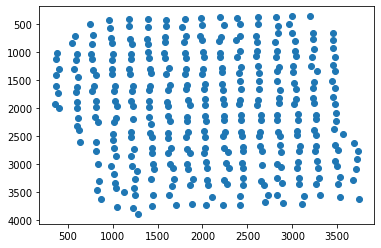

In [4]:
plt.gca().invert_yaxis()
plt.scatter(phenoCoords[:,0],phenoCoords[:,1])

In [5]:
dfRewards = pd.read_csv("exported_metrics.cvs")

In [37]:
np.save('heitorCentroids', np.array(list(zip(dfRewards.Centroid_y, dfRewards.Centroid_x))))

In [39]:
hi = np.load('heitorCentroids.npy')

In [41]:
pattInit = np.load("centroidsInitCorrected.npy")

In [44]:
len(hi)

350

In [43]:
len(pattInit)

350

In [6]:
dfRewards.head()

,Dipole,Elongation,Aspect_Ratio,Centroid_x,Centroid_y
0,0.951783,137.0,0.637681,5985,1971
1,0.950630,222.0,0.369176,5790,1609
2,0.877684,300.0,0.409836,5821,1886
3,0.843055,298.0,0.344729,5769,2206
4,0.858235,263.0,0.429032,5747,3140


(array([22., 37., 30., 47., 45., 28., 44., 40., 30., 27.]),
 array([ 543. , 1064.5, 1586. , 2107.5, 2629. , 3150.5, 3672. , 4193.5,
        4715. , 5236.5, 5758. ]),
 <BarContainer object of 10 artists>)

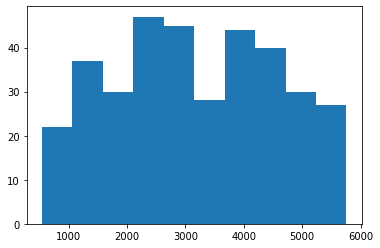

In [7]:
plt.hist(dfRewards.Centroid_y.values)

(array([22., 37., 30., 47., 45., 28., 44., 40., 30., 27.]),
 array([ 353.965 ,  692.8759, 1031.7868, 1370.6977, 1709.6086, 2048.5195,
        2387.4304, 2726.3413, 3065.2522, 3404.1631, 3743.074 ]),
 <BarContainer object of 10 artists>)

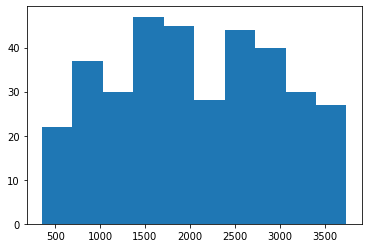

In [8]:
plt.hist(df.XM.values)

### CAD Coordinates

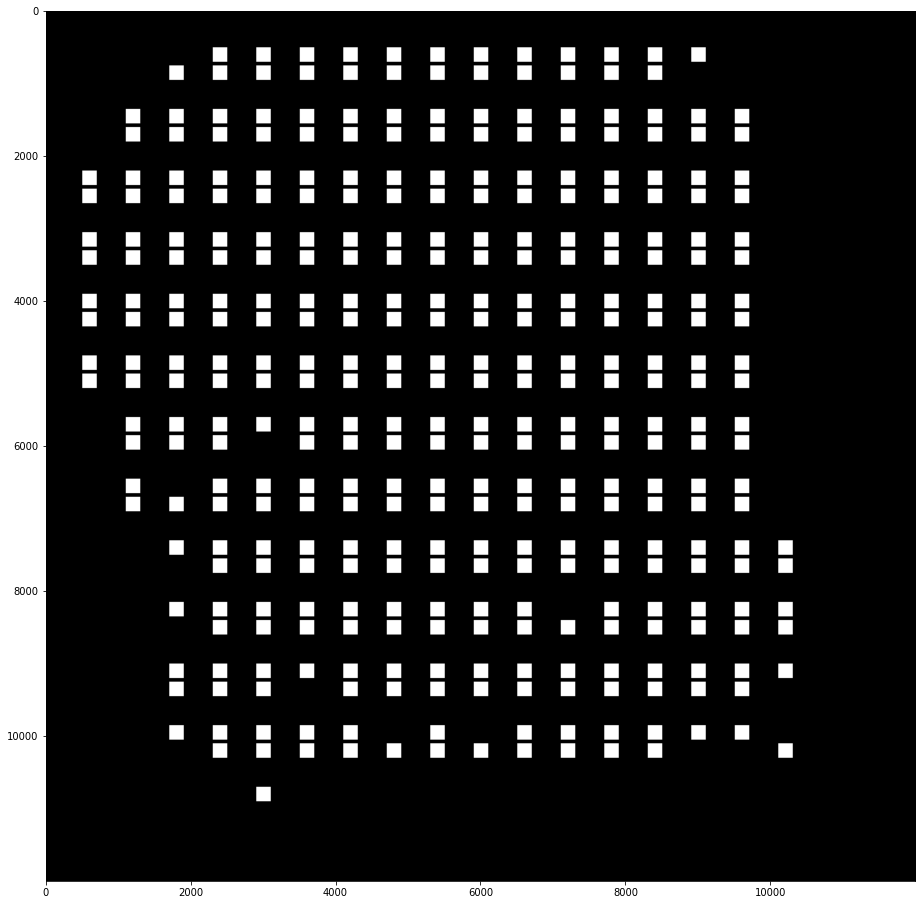

In [19]:
# PAIRED ARRAY GENERATION

b1 = np.ones((13,17))
b2 = np.ones((12,17))
res1_lo = np.argwhere(b1 == 1)
res2_lo = np.argwhere(b2 == 1)
res1_empty = np.array(
    [0,1,2,15,16,17,
     17*2-1,17*3-1,17*4-1,17*5-1,17*6-1,
     17*6,17*7-1,17*7,17*7+2,17*8-1,
     17*8,17*8+1,17*9,17*9+1,17*9+11,
     17*10,17*10+1,17*11,17*11+1,17*11+7,17*11+9,
     17*12-1,17*12,17*12+1,17*12+2,17*12+3,17*12+5,
     17*12+6,17*12+7,17*12+8,17*12+9,17*12+10,17*12+11,
     17*12+12,17*12+13,17*12+14,17*12+15,17*12+16])
res2_empty = np.array(
    [0,1,14,15,16,17,
     17*2-1,17*3-1,17*4-1,17*5-1,17*6-1,
     17*6,17*6+4,17*7-1,17*7,17*8-1,
     17*8,17*8+1,17*8+2,17*9,17*9+1,17*9+2,
     17*10,17*10+1,17*10+5,17*11-1,17*11,17*11+1,
     17*11+2,17*11+14,17*11+15])

res1_lo = np.delete(res1_lo, res1_empty, axis=0)
res2_lo = np.delete(res2_lo, res2_empty, axis=0)

res1 = np.array([np.array([yi*850, xi*600])+500 for yi, xi in res1_lo])
res2 = np.array([np.array([yi*850, xi*600])+500 for yi, xi in res2_lo])
centroids = []

im = np.zeros((12000, 12000))
for k in range(res1.shape[0]):
    y, x = res1[k][0], res1[k][1]
    im[y:y+200,x:x+200] = 255
    centroids.append((x+100, y+100))
    #im[y+90:y+100, x+90:x+100] = 0
for k in range(res2.shape[0]):
    y, x = res2[k][0], res2[k][1]
    im[y+250:y+450,x:x+200] = 255
    #im[y+340:y+350, x+90:x+100] = 0
    centroids.append((x+100, y+350))

plt.figure(figsize=(16,16))
plt.imshow(im, plt.cm.gray)
plt.show()



In [20]:
im

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Find Canny edges
edged = cv2.Canny(im.astype(np.uint8), 30, 200)

contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
len(contours)

In [6]:
CADcoords = []

for cnt in contours:
    M = cv2.moments(cnt)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    CADcoords.append((cX, cY))
    
CADcoords = np.array(CADcoords)
CADcoords[:5]

array([[ 2999, 10799],
       [10199, 10199],
       [ 8399, 10199],
       [ 7799, 10199],
       [ 7199, 10199]])

In [143]:
centroids = np.array(centroids)

In [154]:
np.save('centroidsInitCorrected', centroids)

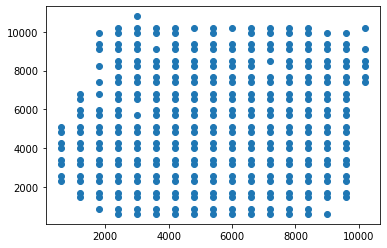

In [146]:
plt.scatter(centroids[:,0], centroids[:,1])

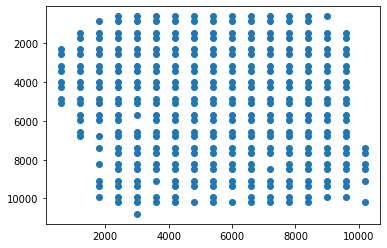

In [7]:
plt.gca().invert_yaxis()
plt.scatter(CADcoords[:,0], CADcoords[:,1])

In [8]:
CADcoords.shape, phenoCoords.shape

((350, 2), (350, 2))

# Grouping Algorithm

In [13]:
def grouping(coordsTrue, coordsPheno, plot=False):
    
    orgNumsYaxisAscending = NumOrgs(coordsTrue)
    
    # outputs dictionary of color keys and associated coordinates
    groupsTrue = groupOrgs(coordsTrue, orgNumsYaxisAscending, showPlot = plot)
    groupsPheno = groupOrgs(coordsPheno, orgNumsYaxisAscending, showPlot = plot)
    
    # returns array of coordinates and list of colors
    return ColorDict2Arr(groupsTrue), ColorDict2Arr(groupsPheno)

def ColorDict2Arr(colsDict):
    keys = list(colsDict.keys())

    coordList = []
    colList = []
    for key in keys:
        col = re.sub(r'[0-9]+', '', key)
        colList.extend([col for _ in range(len(colsDict[key]))])
        coordList.append(np.array(colsDict[key]))

    return np.vstack(coordList), colList

def NumOrgs(designCoords):
    # get counts of organoids wrt y axis values
    OrgsCnts = Counter(designCoords[:,1])
    # sort y axis keys in ascending order
    OrgsCntsSorted = sorted(OrgsCnts.items())
    # return sorted counts
    return np.array(OrgsCntsSorted)[:,1]

def groupOrgs(coords, cnts, showPlot = False):
    # sort y coordinates in ascending order 
    coordsYsort = sorted(coords, key = lambda x: x[1])

    # make dictionary for grouping organoids
    patternDict = {}
    colors_used = [0,0,0,0,0,0]

    # Colors used for plot and grouping organoids
    colors = ['magenta','green', 'brown', 'blue','orange', 'red']
    
    if showPlot:
        plt.figure(figsize=(8,8))

    num_col = len(colors)
    start = 0
    # loop through y axis layers, plot groups and save in dictionary
    for ix, num in enumerate(cnts):
        col_ix = ix % num_col
        vals = np.array(coordsYsort[start:start+num])
        valsXsort = sorted(vals, key = lambda x: x[0])
        currColor = colors[col_ix]

        # if color not in dictionary, add color
        # else denote its index e.g. blue3
        if currColor not in patternDict:
            patternDict[currColor] = valsXsort
        else:
            key_num = colors_used[col_ix]
            newKey_num = key_num + 1
            key_name = currColor + str(newKey_num)
            patternDict[key_name] = valsXsort
            colors_used[col_ix] = newKey_num

        if showPlot:
            plt.scatter(np.array(vals)[:,0], np.array(vals)[:,1], c = currColor)
        
        start = start+num
    
    if showPlot:
        # flip y axis for plotting purposes
        plt.gca().invert_yaxis()
        plt.show()
    
    return patternDict

In [14]:
cadColors, phenoColors = grouping(CADcoords, phenoCoords)

# Matching Algorithm

### Input Formatting for Matching

In [17]:
egClicks = [(1290.89, 3878.795), (1286.881, 3878.795), (1286.881, 3889.166), (1294.898, 3863.238)]

In [25]:
clickTile = np.tile(np.array(egClicks[0]), (phenoColors[0].shape[0],1))

In [35]:
335.591**2

112621.319281

In [34]:
(clickTile - phenoColors[0])

array([[  335.591,  3459.281],
       [  106.704,  3475.161],
       [  -97.231,  3468.625],
       [ -301.935,  3463.222],
       [ -510.696,  3480.772],
       [ -689.553,  3491.939],
       [ -900.767,  3504.273],
       [-1089.245,  3493.168],
       [-1325.596,  3516.228],
       [-1528.383,  3510.476],
       [-1702.714,  3525.129],
       [-1904.134,  3524.375],
       [  543.632,  3385.723],
       [  315.244,  3322.759],
       [  113.395,  3351.963],
       [ -104.309,  3331.196],
       [ -306.645,  3349.71 ],
       [ -478.362,  3336.507],
       [ -703.358,  3360.005],
       [ -948.426,  3369.35 ],
       [-1129.055,  3391.968],
       [-1329.742,  3377.762],
       [-1549.636,  3357.856],
       [-1676.023,  3381.472],
       [  708.571,  3167.757],
       [  506.865,  3183.904],
       [  309.187,  3127.115],
       [   99.988,  3119.493],
       [  -96.459,  3117.85 ],
       [ -296.749,  3145.545],
       [ -521.942,  3180.682],
       [ -683.897,  3175.78 ],
       [

In [33]:
(clickTile - phenoColors[0])*(clickTile - phenoColors[0])

array([[1.12621319e+05, 1.19666250e+07],
       [1.13857436e+04, 1.20767440e+07],
       [9.45386736e+03, 1.20313594e+07],
       [9.11647442e+04, 1.19939066e+07],
       [2.60810404e+05, 1.21157737e+07],
       [4.75483340e+05, 1.21936380e+07],
       [8.11381188e+05, 1.22799293e+07],
       [1.18645467e+06, 1.22022227e+07],
       [1.75720476e+06, 1.23638593e+07],
       [2.33595459e+06, 1.23234417e+07],
       [2.89923497e+06, 1.24265345e+07],
       [3.62572629e+06, 1.24212191e+07],
       [2.95535751e+05, 1.14631202e+07],
       [9.93787795e+04, 1.10407274e+07],
       [1.28584260e+04, 1.12356560e+07],
       [1.08803675e+04, 1.10968668e+07],
       [9.40311560e+04, 1.12205571e+07],
       [2.28830203e+05, 1.11322790e+07],
       [4.94712476e+05, 1.12896336e+07],
       [8.99511877e+05, 1.13525194e+07],
       [1.27476519e+06, 1.15054469e+07],
       [1.76821379e+06, 1.14092761e+07],
       [2.40137173e+06, 1.12751969e+07],
       [2.80905310e+06, 1.14343529e+07],
       [5.020728

In [37]:
np.sum((clickTile - phenoColors[0])*(clickTile - phenoColors[0]), 1)

array([1.20792464e+07, 1.20881297e+07, 1.20408133e+07, 1.20850714e+07,
       1.23765841e+07, 1.26691213e+07, 1.30913104e+07, 1.33886773e+07,
       1.41210641e+07, 1.46593963e+07, 1.53257694e+07, 1.60469454e+07,
       1.17586560e+07, 1.11401062e+07, 1.12485144e+07, 1.11077472e+07,
       1.13145882e+07, 1.13611092e+07, 1.17843461e+07, 1.22520313e+07,
       1.27802121e+07, 1.31774899e+07, 1.36765686e+07, 1.42434060e+07,
       1.05367573e+07, 1.03941568e+07, 9.87444482e+06, 9.74123418e+06,
       9.73029296e+06, 9.98251332e+06, 1.03891614e+07, 1.05532937e+07,
       1.08055554e+07, 1.13596452e+07, 1.17798973e+07, 1.27679935e+07,
       1.33366922e+07, 1.41717288e+07, 1.51058554e+07, 9.86774968e+06,
       9.46747482e+06, 9.34604872e+06, 9.15249366e+06, 9.16363586e+06,
       9.49517161e+06, 9.63212685e+06, 1.00782397e+07, 1.03264633e+07,
       1.07483107e+07, 1.11732459e+07, 1.17405799e+07, 1.24802480e+07,
       1.34382668e+07, 1.42773576e+07, 9.05853487e+06, 8.62047972e+06,
      

In [38]:
np.argmin(np.sum((clickTile - phenoColors[0])*(clickTile - phenoColors[0]), 1))

349

In [39]:
phenoColors[0][349]

array([1282.548, 3889.322])

In [43]:
colors = ['b']*350
colors[349] = 'r'
colors

['b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b'

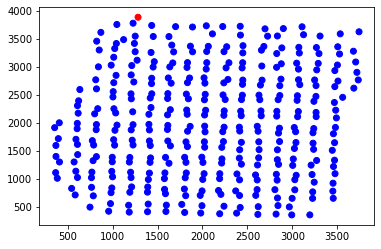

In [44]:
plt.scatter(phenoColors[0][:,0], phenoColors[0][:,1], c=colors)

In [211]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import sys

class Organoid:
    def __init__(self, saveDir, saveLog = False):
        self.saveDir = saveDir
        self.saveLog = saveLog

    def coloring(self, coords, colors):
        X = coords[:,0]
        Y = coords[:,1]
        assert(len(X) == len(Y) == len(colors))
        DataLog = []

        figColor = plt.figure()
        for i, (x,y) in enumerate(zip(X,Y)):
            plt.scatter(x, y, c = colors[i], picker=5)

        def onclick_color(event):
            print()
            print('*** MODIFYING COLOR ***')
            val = input("Enter value g/r/b: ")
            event.artist.set_color(val)
            figColor.canvas.draw()
            data = np.frombuffer(figColor.canvas.tostring_rgb(), dtype=np.uint8) #sep=''
            data = data.reshape(figColor.canvas.get_width_height()[::-1] + (3,))
            DataLog.append(data)
            print(len(DataLog))
            print(DataLog[-1].shape)
            plt.savefig(os.path.join(self.saveDir, "outputFig.png"), bbox_inches=0, pad_inches = 0)

        cid = figColor.canvas.mpl_connect('pick_event', onclick_color)

        plt.show()

    def removal(self, coords):
        X = coords[:,0]
        Y = coords[:,1]
        assert(len(X) == len(Y))
        DataLog = []

        figRm = plt.figure()
        for i, (x,y) in enumerate(zip(X,Y)):
            plt.scatter(x, y, c = 'b', picker=5)

        def onclick_remove(event):
            event.artist.remove()
            figRm.canvas.draw()
            data = np.frombuffer(figRm.canvas.tostring_rgb(), dtype=np.uint8)
            data = data.reshape(figRm.canvas.get_width_height()[::-1] + (3,))
            DataLog.append(data)
            plt.savefig(os.path.join(self.saveDir, "outputFig.png"), bbox_inches=0, pad_inches = 0)

        cid = figRm.canvas.mpl_connect('pick_event', onclick_remove)
        plt.gca().invert_yaxis()
        plt.show()

### Developmental Excess

In [ ]:
# swap coordinates between groups
def swap(str1, int1, str2, int2):
    patternDict[str1][int1], patternDict[str2][int2] = patternDict[str2][int2], patternDict[str1][int1]
# move coordinate to a group
def move(str1, int1, str2):
    popEl = patternDict[str1].pop(int1)
    patternDict[str2].append(popEl)
    patternDict[str2] = sorted(patternDict[str2], key = lambda x: x[0])
    

221 177
204 174
177
174


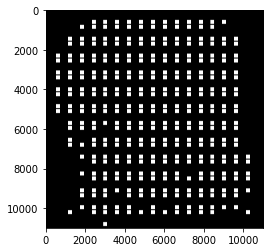

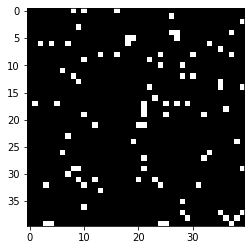

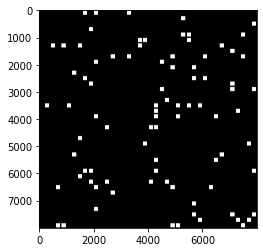

In [4]:

# RANDOM ARRAY
# each pixel is 200 x 200 micron (150 x 150 micron square with 25 µm padding)
# overall patterning area is 8000 x 8000 micron (40 x 40 pixels)
# 1/16 of pixels (100/1600 pixels) are filled on average

np.random.seed(3) # set random seed for reproducibility
f = 1/16
a = np.random.rand(40,40) 
b = np.where(a < f, 1, 0) # binary image
plt.figure()
plt.imshow(b, plt.cm.gray)

# generate full array, where each pixel is now 1 x 1 micron
res_lo = np.argwhere(b == 1)
res = res_lo*200+25
im = np.zeros((8000, 8000))
for k in range(res.shape[0]):
    y, x = res[k][0], res[k][1]
    im[y:y+150,x:x+150] = 1
plt.figure()
plt.imshow(im, plt.cm.gray)
plt.show()

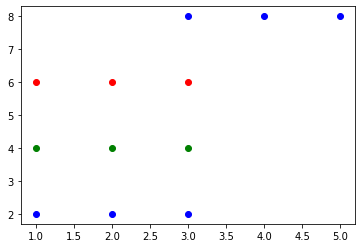

In [13]:
x = [1,2,3,1,2,3,1,2,3,3,4,5]
y = [2,2,2,4,4,4,6,6,6,8,8,8]
c_ = ['b', 'b', 'b', 'g','g', 'g','r', 'r','r','b', 'b', 'b']

for i, (x,y) in enumerate(zip(x,y)):
        an = plt.scatter(x,y,c=c_[i],picker=5)


In [ ]:
colorArrs = np.load('colorArrs.npz')
fs = hi.files
orig = colorArrs[fs[0]]
mod = colorArrs[fs[1]]
np.sum([orig[i] == mod[i] for i in range(len(orig))])

1294.898 3878.795
Color mod options: magenta/green/blue/yellow/red
Enter value m/g/b/y/r: m
Current Color is r.
New Color is m.
Figures 2 has been closed.
Figures 1 has been closed.
349
m

# Making 50 by 50 localities

In [47]:
df = pd.read_csv("matchedDF.csv")
df.head()

,xInit,yInit,colorInit,xPheno,yPheno,colorPheno
0,2400,600,m,955.299,419.514,m
1,3000,600,m,1184.186,403.634,m
2,3600,600,m,1388.121,410.170,m
3,4200,600,m,1592.825,415.573,m
4,4800,600,m,1801.586,398.023,m


In [48]:
df[df.yInit == 600].xvalues

,xInit,yInit,colorInit,xPheno,yPheno,colorPheno
0,2400,600,m,955.299,419.514,m
1,3000,600,m,1184.186,403.634,m
2,3600,600,m,1388.121,410.170,m
3,4200,600,m,1592.825,415.573,m
4,4800,600,m,1801.586,398.023,m
5,5400,600,m,1980.443,386.856,m
6,6000,600,m,2191.657,374.522,m
7,6600,600,m,2380.135,385.627,m
8,7200,600,m,2616.486,362.567,m
9,7800,600,m,2819.273,368.319,m


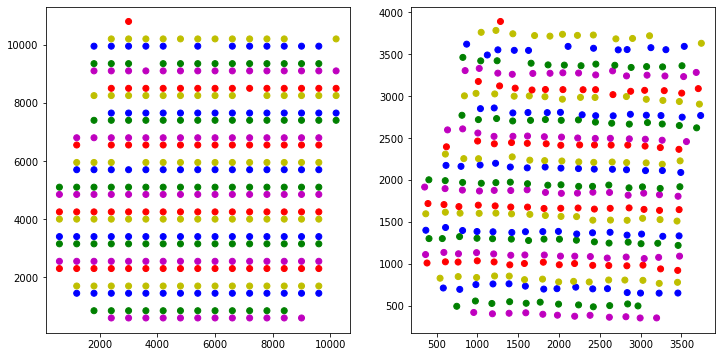

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12,6)
#plt.figure(figsize=(6,6))
ax1.scatter(df.xInit, df.yInit, c=df.colorInit)
ax2.scatter(df.xPheno, df.yPheno, c=df.colorPheno)

In [4]:
coords = np.array(list(zip(df.xInit.values, df.yInit.values)))

In [8]:
coordsNorm = coords//50

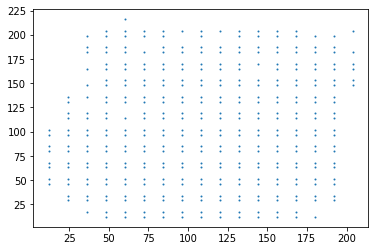

In [9]:
plt.scatter(coordsNorm[:,0],coordsNorm[:,1], s=1)

In [10]:
paddingNorm = 1000//50 # relative to normed sideLen

In [11]:
np.max(coordsNorm[:,0]) - np.min(coordsNorm[:,0])

192

In [12]:
xRange = (np.max(coordsNorm[:,0]) - np.min(coordsNorm[:,0])) + 3*paddingNorm
yRange = (np.max(coordsNorm[:,1]) - np.min(coordsNorm[:,1])) + 3*paddingNorm
globalLen = max(xRange, yRange)

In [13]:
globalLen

264

(0.0, 264.0)

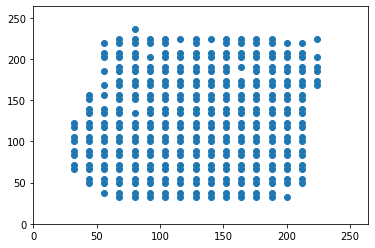

In [65]:
newx, newy = coordsNorm[:,0]+paddingNorm, coordsNorm[:,1]+paddingNorm
plt.scatter(coordsNorm[:,0]+paddingNorm, coordsNorm[:,1]+paddingNorm)
plt.xlim(0,globalLen)
plt.ylim(0,globalLen)


In [90]:
newMat = np.zeros((globalLen, globalLen))

In [91]:
newMat.shape

(264, 264)

In [92]:
for x,y in list(zip(newx,newy)):
    bLeftx, bLefty = x-1, y-1
    for xShift in range(4):
        for yShift in range(4):
            newMat[bLeftx + xShift, bLefty + yShift] = 1

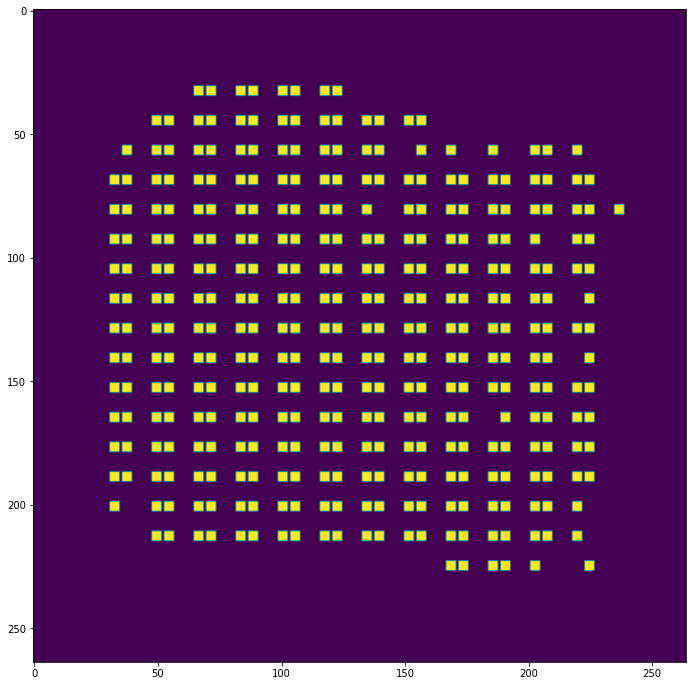

In [93]:
plt.figure(figsize=(12,12))
plt.imshow(newMat)

In [94]:
coordsNorm[130]

array([156,  80])

In [95]:
newMat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
df = pd.read_csv("matchedDF.csv")
df.head()

,xInit,yInit,colorInit,xPheno,yPheno,colorPheno
0,2400,600,m,955.299,419.514,m
1,3000,600,m,1184.186,403.634,m
2,3600,600,m,1388.121,410.170,m
3,4200,600,m,1592.825,415.573,m
4,4800,600,m,1801.586,398.023,m


In [10]:
hi = (df[df.yInit == 600].xInit.values)//50
[hi[i+1]-hi[i] for i in range(len(hi)-1)]

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]

In [11]:
coords = np.array(list(zip(df.xInit.values, df.yInit.values)))

In [12]:
def findNeighbors(coords, searchLen):
    searchLenNorm = searchLen//50
    coordsNorm = coords//50
    
    xRange = (np.max(coordsNorm[:,0]) - np.min(coordsNorm[:,0])) + 3*searchLenNorm
    yRange = (np.max(coordsNorm[:,1]) - np.min(coordsNorm[:,1])) + 3*searchLenNorm
    globalLen = max(xRange, yRange)
    
    newMat = np.zeros((globalLen, globalLen))
    newx, newy = coordsNorm[:,0]+searchLenNorm, coordsNorm[:,1]+searchLenNorm
    
    for x,y in list(zip(newx,newy)):
        bLeftx, bLefty = x-1, y-1
        for xShift in range(4):
            for yShift in range(4):
                newMat[bLeftx + xShift, bLefty + yShift] = 1
    
    # search length and boxSideLen in microns
    testX = newx[130]
    testY = newy[130]
    
    newMat[testX,testY] = 0
    
    xbndL, xbndU = testX - searchLenNorm+1, testX + searchLenNorm+1
    ybndL, ybndU = testY - searchLenNorm+1, testY + searchLenNorm+1
    
    bbox = newMat[xbndL:xbndU, ybndL:ybndU]
    
    #xBBox = (coordsNorm[:,0] >= xbndL) & (coordsNorm[:,0] <= xbndU)
    #yBBox = (coordsNorm[:,1] >= ybndL) & (coordsNorm[:,1] <= ybndU)
    #neighborIX = np.where(xbool & ybool)
    
    return bbox
    
nbrs = findNeighbors(coords, 1000)



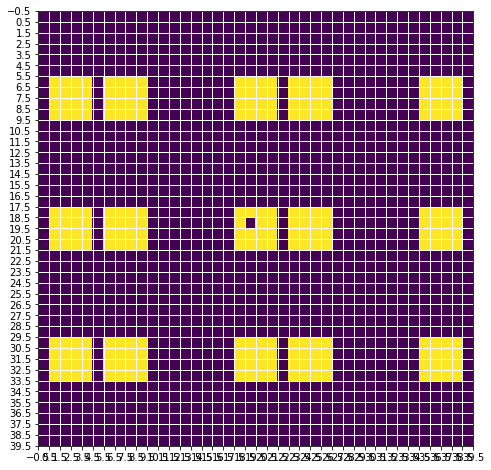

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(nbrs)
ax = plt.gca()
#ax.invert_yaxis()
ax.set_xticks(np.arange(-0.5, 40, 1))
ax.set_yticks(np.arange(-0.5, 40, 1))
ax.grid(which='major', color='w', linestyle='-', linewidth=1)

In [16]:
xR = dfRewards.Centroid_y.values
yR = dfRewards.Centroid_x.values
xRel = df.xPheno.values
yRel = df.yPheno.values

coordR = np.array(list(zip(xR, yR)))
coordRel = np.array(list(zip(xRel, yRel)))

(array([22., 37., 30., 47., 45., 28., 44., 40., 30., 27.]),
 array([ 543. , 1064.5, 1586. , 2107.5, 2629. , 3150.5, 3672. , 4193.5,
        4715. , 5236.5, 5758. ]),
 <BarContainer object of 10 artists>)

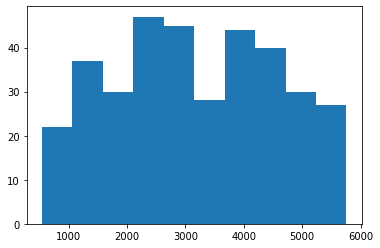

In [32]:
plt.hist(xR)

(array([22., 37., 30., 47., 45., 28., 44., 40., 30., 27.]),
 array([ 353.965 ,  692.8759, 1031.7868, 1370.6977, 1709.6086, 2048.5195,
        2387.4304, 2726.3413, 3065.2522, 3404.1631, 3743.074 ]),
 <BarContainer object of 10 artists>)

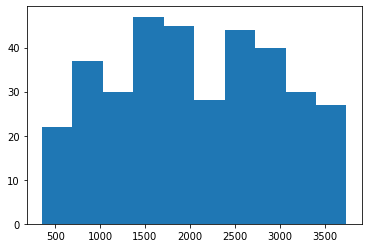

In [33]:
plt.hist(xRel)

In [17]:
len(coordR), len(coordRel)

(350, 350)

In [29]:
ixVec = []
N = len(coordRel)
for coord in coordR:    
    v = np.tile(coord, (350, 1))
    diff = v - coordRel
    hi = np.absolute(diff)
    ixVec.append(np.argmin(hi))
    #sumSqDiff = np.sum(diff*diff, axis=1)
    #ix = (sumSqDiff)
    #ixVec.append(ix)

In [31]:
len(np.unique(ixVec)), len(ixVec)

(183, 350)

In [34]:
ixVec

[62,
 310,
 682,
 64,
 668,
 16,
 266,
 692,
 564,
 696,
 696,
 699,
 696,
 56,
 136,
 696,
 536,
 696,
 696,
 604,
 638,
 699,
 696,
 468,
 680,
 570,
 32,
 604,
 162,
 530,
 696,
 696,
 22,
 392,
 696,
 699,
 120,
 696,
 699,
 698,
 696,
 668,
 162,
 699,
 692,
 266,
 604,
 696,
 696,
 696,
 158,
 699,
 699,
 120,
 62,
 434,
 18,
 620,
 696,
 162,
 668,
 696,
 699,
 699,
 699,
 572,
 520,
 699,
 698,
 638,
 696,
 696,
 468,
 100,
 362,
 696,
 668,
 699,
 699,
 699,
 699,
 520,
 32,
 358,
 694,
 638,
 64,
 699,
 506,
 699,
 628,
 696,
 696,
 699,
 699,
 699,
 604,
 120,
 266,
 668,
 18,
 162,
 64,
 696,
 699,
 699,
 699,
 699,
 699,
 699,
 654,
 26,
 120,
 64,
 699,
 100,
 520,
 668,
 699,
 677,
 696,
 266,
 677,
 677,
 677,
 677,
 675,
 679,
 260,
 520,
 683,
 696,
 695,
 683,
 691,
 694,
 693,
 691,
 697,
 665,
 158,
 625,
 698,
 629,
 100,
 629,
 266,
 631,
 629,
 631,
 536,
 639,
 631,
 637,
 647,
 676,
 643,
 18,
 595,
 613,
 623,
 694,
 605,
 603,
 601,
 617,
 617,
 621,
 422,
 